This skeleton code will get you started with the assignment.

For this assignment you will need at least:

- Pytorch 1.13+
- Sklearn
- Matplotlib

In [127]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from IPython.display import Audio
from torchsummary import summary

#possibly unnecessary:
import torch.nn as nn
import torch.utils.data as data_utils
import logging
from torch import optim
from torchaudio import transforms
#import torchtext

In [128]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cpu


### Data Loading
The data consists of waveforms of audioclips sampled 8000 times per second (8 khz).
The data is stored in 16 bit precision to reduce storage size. We first need to
convert the waveforms to 32 bit precision.

In [129]:
sampling_rate = 8_000
languages = ["de", "en", "es", "fr", "nl", "pt"]
language_dict = {languages[i]: i for i in range(len(languages))}

X_train, y_train = np.load("dataset/inputs_train_fp16.npy"), np.load(
    "dataset/targets_train_int8.npy"
)
X_test, y_test = np.load("dataset/inputs_test_fp16.npy"), np.load(
    "dataset/targets_test_int8.npy"
)

X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)


Change the `selected_language` to any of the 6 language codes, and re-run the cell below to hear some random clips from the training data.

In [130]:
selected_language = "nl"
idxs = np.where(y_train == language_dict[selected_language])[0]
idx = np.random.choice(idxs)

Audio(X_train[idx], rate=sampling_rate)


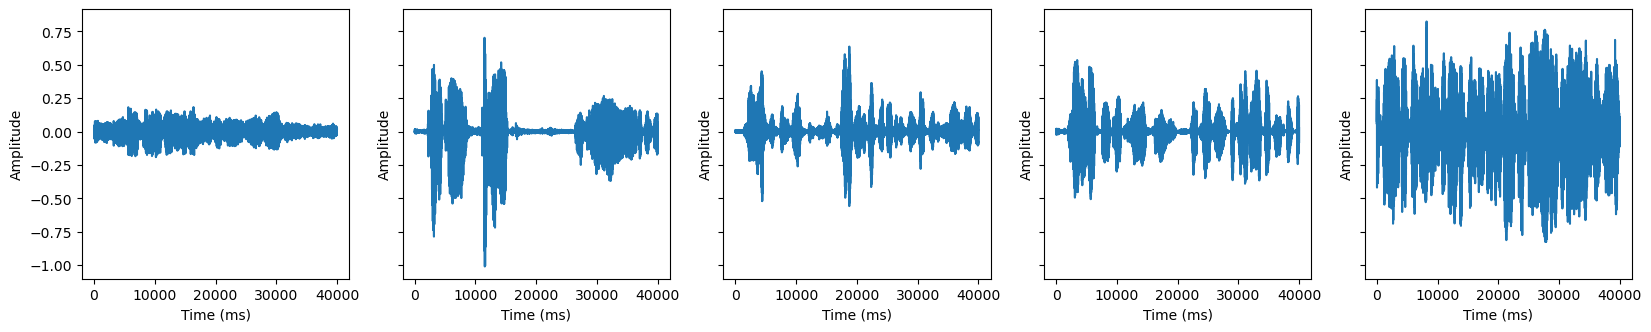

In [131]:
indexes_random = np.random.choice(6000, 5)

time = np.linspace(0, 39999, 40000)

fig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey = True)
for ax, audio_index in zip(axes,indexes_random):
    ax.plot(time, X_train[audio_index])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')


### Data pre-processing

It is important that data preprocessing takes place in the model itself,
as only the model will be uploaded to the competition server.

So, rather than the usual, we will perform normalization and other preprocessing
steps as layers of the network. To help you with this, we provide an example of
a bogus normalization below.


Here, we multiply the input by a constant and subtract the max of each sample.
Follow this format to create your own normalization layer(s).

In [133]:
# normalization with MFCC

sample_rate = 40000/5
transform_MFCC = transforms.MFCC(sample_rate = sample_rate)

class MFCC(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        with torch.no_grad():
            x = transform_MFCC(x)
            #x = x.reshape(-1, 1, 40, 201) ###possibly comment out
        return x
    
MFCC_transformation = MFCC()

In [146]:
# testing different mfcc methods
'''
tensor_X_train = torch.tensor(X_train_sub)

transformed_tensor = MFCC_transformation(tensor_X_train)

import librosa
from matplotlib import cm

img = tensor_X_train[0]
print(img)
print(img.shape)

y = np.array(img)
sr = 40000/5

new = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
print(mfcc.shape)

plt.figure(figsize=(6, 4))
librosa.display.specshow(new, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,3.5))
plt.imshow(old, cmap=cm.magma, origin = 'lower')
plt.xlabel('Freq_bins')
plt.ylabel('Coefficients')
plt.title("MFCC")
plt.show()
'''

'\ntensor_X_train = torch.tensor(X_train_sub)\n\ntransformed_tensor = MFCC_transformation(tensor_X_train)\n\nimport librosa\nfrom matplotlib import cm\n\nimg = tensor_X_train[0]\nprint(img)\nprint(img.shape)\n\ny = np.array(img)\nsr = 40000/5\n\nnew = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)\nprint(mfcc.shape)\n\nplt.figure(figsize=(6, 4))\nlibrosa.display.specshow(new, x_axis=\'time\')\nplt.colorbar()\nplt.title(\'MFCC\')\nplt.tight_layout()\nplt.show()\n\nplt.figure(figsize=(20,3.5))\nplt.imshow(old, cmap=cm.magma, origin = \'lower\')\nplt.xlabel(\'Freq_bins\')\nplt.ylabel(\'Coefficients\')\nplt.title("MFCC")\nplt.show()\n'

In [135]:
# isolating english and spanish for the initial model creation

idxs = np.where((y_train == language_dict['en'])|(y_train == language_dict['es'])) 
idxs_test = np.where((y_test == language_dict['en'])|(y_test == language_dict['es'])) 

y_train_sub = y_train[idxs]-1
X_train_sub = X_train[idxs]

y_test_sub = y_test[idxs_test]-1
X_test_sub = X_test[idxs_test]

print(np.shape(X_train_sub)) #samples, timesteps
print(np.shape(X_test_sub))


(2000, 40000)
(400, 40000)


### One-Hot Encoder

In [8]:
"""""
# makeshift one hot encoder
y_train_sub_ohe = y_train_sub - 1
y_test_sub_ohe = y_test_sub - 1

y_train_spain_ohe = np.array([1 if x == 0 else 0 for x in y_train_sub_ohe])
y_train_english_ohe = y_train_sub_ohe

y_test_spain_ohe = np.array([1 if x == 0 else 0 for x in y_test_sub_ohe])
y_test_english_ohe = y_test_sub_ohe

#print(y_train_spain_ohe[:5])
#print(y_train_english_ohe[:5])

y_train_sub = np.array([y_train_spain_ohe, y_train_english_ohe])
y_test_sub = np.array([y_test_spain_ohe, y_test_english_ohe])

print(y_train_sub)
#print(y_test_sub)

print(y_train_sub.shape)
print(y_test_sub.shape)

y_train_sub = np.swapaxes(y_train_sub, 0, 1)
y_test_sub = np.swapaxes(y_test_sub, 0, 1)

print(y_train_sub.shape)
print(y_test_sub.shape)
"""""

[[0 0 0 ... 1 0 1]
 [1 1 1 ... 0 1 0]]
(2, 2000)
(2, 400)
(2000, 2)
(400, 2)


### MFCC transformation on X_train and X_test
+turning it into tensors

In [137]:
# input
tensor_X_train = MFCC_transformation(torch.tensor(X_train_sub))
tensor_X_test = MFCC_transformation(torch.tensor(X_test_sub))

# target
tensor_y_train = torch.tensor(y_train_sub)
tensor_y_test = torch.tensor(y_test_sub)

### Plot of non-normalized vs normalized data

In [26]:
"""
# transforming the dataset to MFCC

from matplotlib import cm

transformed_array = np.array(tensor_X_train)

indexes = [100, 200, 300, 400, 500]

fig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey=True, dpi=80)
time = np.linspace(0, 39999, 40000)

for ax, audio_index in zip(axes,indexes):
    ax.plot(time, X_train_sub[audio_index])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')

plt.savefig('waveform graphs.png')


fig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey=True, dpi=80)
for ax, audio_index in zip(axes,indexes):
    ax.imshow(transformed_array[audio_index], cmap=cm.magma, origin = 'lower')
    ax.set_xlabel('Freq_bins')
    ax.set_ylabel('Coefficients')
    ax.set_title("MFCC")
    
#plt.savefig('spectrograms.png')
"""

'\n# transforming the dataset to MFCC\n\nfrom matplotlib import cm\n\ntransformed_tensor = MFCC_transformation(tensor_X_train)\ntransformed_array = np.array(transformed_tensor)\n\nindexes = [100, 200, 300, 400, 500]\n\nfig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey=True, dpi=80)\ntime = np.linspace(0, 39999, 40000)\n\nfor ax, audio_index in zip(axes,indexes):\n    ax.plot(time, X_train_sub[audio_index])\n    ax.set_xlabel(\'Time (ms)\')\n    ax.set_ylabel(\'Amplitude\')\n\nplt.savefig(\'waveform graphs.png\')\n\n\nfig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey=True, dpi=80)\nfor ax, audio_index in zip(axes,indexes):\n    ax.imshow(transformed_array[audio_index], cmap=cm.magma, origin = \'lower\')\n    ax.set_xlabel(\'Freq_bins\')\n    ax.set_ylabel(\'Coefficients\')\n    ax.set_title("MFCC")\n    \n#plt.savefig(\'spectrograms.png\')\n'

### CNN model

In [142]:
# Create a sequential model - CNN
# (batch, channel, image height, image width)

model = nn.Sequential()

# Add convolutional and pooling layers
model.add_module('Conv_1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1))
model.add_module('Relu_1', nn.ReLU())
model.add_module('MaxPool_1', nn.MaxPool2d(kernel_size=2, padding=1))

model.add_module('Conv_2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1))
model.add_module('Relu_2', nn.ReLU())
model.add_module('MaxPool_2', nn.MaxPool2d(kernel_size=2, padding=1))

model.add_module('Conv_3', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1))
model.add_module('Relu_3', nn.ReLU())


model.add_module('Flatten', nn.Flatten())
# in_features for linear layer should be the multiplication of the last 3 digits of the ReLU-8 output shape (64*11*51)
# which is equal to the last number in the Flatten output shape (35904)
model.add_module('Linear_1', nn.Linear(in_features=64*11*51, out_features=64, bias=True)) 
model.add_module('Relu_L_1', nn.ReLU())
model.add_module('Linear_2', nn.Linear(in_features=64, out_features=10, bias=True))
model.add_module('Out_activation', nn.Softmax(-1))

model = model.to(device)

summary(model, input_size = (1, 40, 201)) # testing input size without defined batch_size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 40, 201]             320
              ReLU-2          [-1, 32, 40, 201]               0
         MaxPool2d-3          [-1, 32, 21, 101]               0
            Conv2d-4          [-1, 64, 21, 101]          18,496
              ReLU-5          [-1, 64, 21, 101]               0
         MaxPool2d-6           [-1, 64, 11, 51]               0
            Conv2d-7           [-1, 64, 11, 51]          36,928
              ReLU-8           [-1, 64, 11, 51]               0
           Flatten-9                [-1, 35904]               0
           Linear-10                   [-1, 64]       2,297,920
             ReLU-11                   [-1, 64]               0
           Linear-12                   [-1, 10]             650
          Softmax-13                   [-1, 10]               0
Total params: 2,354,314
Trainable param

In pytorch, nn.Conv2d assumes the input (mostly image data) is shaped like: [B, C_in, H, W], where B is the batch size, C_in is the number of channels, H and W are the height and width of the image. The output has a similar shape [B, C_out, H_out, W_out]. Here, C_in and C_out are in_channels and out_channels, respectively. (H_out, W_out) is the output image size, which may or may not equal (H, W), depending on the kernel size, the stride and the padding.

However, it is confusing to apply conv2d to reduce [128, 248, 46] inputs to [128, 50, 46]. Are they image data with height 248 and width 46? If so you can reshape the inputs to [128, 1, 248, 46] and use in_channels = 1 and out_channels = 1 in conv2d.

Feature batch shape: torch.Size([64, 1, 40, 201])
Labels batch shape: torch.Size([64])


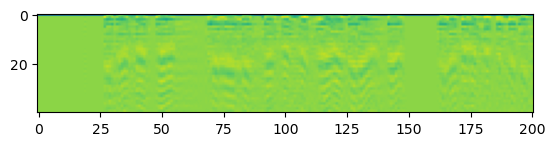

Label: 1


In [143]:
BATCH_SIZE = 64 #aka channels
training = tensor_X_train
target_train = tensor_y_train.long()

test = tensor_X_test
target_test = tensor_y_test.long()

train_dataset = data_utils.TensorDataset(training.unsqueeze(1), target_train) # unsqueeze so it gets shape (64, 1, 40, 201)
train_loader = data_utils.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE) 

test_dataset = data_utils.TensorDataset(test.unsqueeze(1), target_test)
test_loader = data_utils.DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE)

# code from https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [145]:
print(training.shape, target_train.shape)
print(training.shape)
print(target_train.shape)

torch.Size([2000, 40, 201]) torch.Size([2000])
torch.Size([2000, 40, 201])
torch.Size([2000])


In [144]:
# training model and obtaining test score

optimizer = optim.RMSprop(model.parameters(), lr=0.001) 
crossentropy_loss = nn.CrossEntropyLoss(reduction='mean')
num_epochs = 5

model.train() 

for epoch in range(num_epochs):
    for images, labels in train_loader: 
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()   
        predictions = model(images)     
        loss = crossentropy_loss(predictions, labels) 
        loss.backward() 
        optimizer.step()

model.eval() 

test_acc = 0 
for images, labels in test_loader: 
    images, labels = images.to(device), labels.to(device)
    predictions = model(images)
    accuracy = (torch.max(predictions, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
    test_acc += accuracy.item()
    
test_acc /= len(test_loader)

print(test_acc)

0.48660714285714285


### RNN model

In [14]:
# RNN (also code from notebooks)
# I have no idea whether this is okay

class Recurrent(nn.Module):
    """
    A class for a recurrent neural network model,
    a GRU/LSTM/RNN layer, and a linear output layer.

    Args:
        input_dim (int): The size of the input vocabulary.
        hidden_dim (int): The number of units in the hidden layer.
        output_dim (int): The size of the output vocabulary.
        recurrent (nn.GRU/nn.LSTM/nn.RNN): The type of recurrent layer to use.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, recurrent):
        super().__init__()
        self.recurrent = recurrent(input_dim, hidden_dim, num_layers=1)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):

        # RNN and GRU return a tuple of (output, h_n) where output has shape
        # (seq_len, batch, hidden_size)
        # and contains the sequence of activations in the final layer of the RNN
        # and h_n has shape (num_layers, batch, hidden_size)
        # and contains the set of activations at the final step in the sequences
        # for each layer
        # LSTM also returns c_n, the state of the memory cell, so we
        # need to adapt the code here.
        output, h_n = self.recurrent(data)

        if type(self.recurrent) == nn.LSTM:
            last = h_n[0][-1, :, :]
        else:
            last = h_n[-1, :, :]

        # We will apply the linear layer to the activation at the end of the
        # input sequence, for the last recurrent layer
        return self.linear(last)

In [15]:
# please check whether this is correct because idk
# it apparently cannot take a 2d shape as input_dim and output_dim, why?

input_dim = MFCC_transformation(torch.tensor(X_train_sub)).shape
output_dim = 1 # Binary classification, thus one dimensional output (0 or 1)

model_GRU = nn.Sequential(MFCC_transformation, Recurrent(input_dim[2], 32, output_dim, nn.GRU))
model_GRU = model_GRU.to(device)


In [25]:
#training = torch.tensor(X_train_sub)
#target = torch.tensor(y_train_sub)
#if torch.cuda.is_available():
#   model = model_GRU.cuda()
#   inputs = training.cuda() 
#   target = target.cuda()
#   print("cuda")
#model(training)

In [26]:
training = torch.tensor(X_train_sub)
target = torch.tensor(y_train_sub)
model_GRU = model_GRU.to(device)
model_GRU(training)

model_GRU.train() 

Sequential(
  (0): MFCC()
  (1): Recurrent(
    (recurrent): GRU(201, 32)
    (linear): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [40]:
import logging
import torchtext
logging.basicConfig(level=logging.INFO)

BATCH_SIZE = 16

train_it, val_it = torchtext.data.Iterator.splits(
    (X_train_sub, X_test_sub), 
    batch_size = BATCH_SIZE,
    device = device)

def train(model, train_it, val_it, optimizer, epochs=10):
    ### PUT YOUR CODE HERE ###

    """Train `model` in batches from `iterator` and return training loss and 
    accuracy."""
    epoch_loss = 0
    epoch_acc = 0 
    record = {}

    model.train() # Enable training mode (for things which differ between training and testing such as dropout)
    for batch in train_it:
        optimizer.zero_grad()
        print(batch)
        text, prev, curr = batch
        pred = model(text, prev)
        loss = criterion(pred, curr)
        record['loss'] = loss
        # We can calculate accuracy by taking the argmax of the logits and comparing with labels.
        acc = accuracy(pred, curr) 
        record['acc'] = acc
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        record['e_loss'] = epoch_loss
        epoch_acc += acc
        record['e_acc'] = epoch_acc
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def param_count(params):
  """Return the number of total parameters."""
  return sum(p.nelement() for p in params)
acc = []
val_acc = []
loss = []
val_loss = []


model = model_GRU
optimizer = torch.optim.Adam(model.parameters())
logging.info(f"Recurrent GRU")
logging.info(f"    Total parameters: {param_count(model.parameters()):10d}")
logging.info(f"Recurrent parameters: {param_count(model.parameters()):10d}")
history = train(model, train_it, val_it, optimizer, epochs=15)
acc.append(history['acc'])
val_acc.append(history['val_acc'])
loss.append(history['loss'])
val_loss.append(history['val_loss'])

ModuleNotFoundError: No module named 'torchtext'

### Model saving

We need to save the model using torchscript, in order to upload the model file to the competition server.
This may give errors for the following reason:

* In your model class, or layer classes, you use numpy functions or arrays, rather than tensors.

Thus make sure that you use torch tensors and functions inside these classes. Almost any numpy function
can also be performed using torch. Look at the torch documentation for further reference.

Saving the model to torchscript

In [ ]:
torch.jit.save(torch.jit.script(model), "model_test.pt")

### Loading the model from torchscript

This is what the competition server will be doing with your uploaded model.

In [ ]:
model = torch.jit.load("model_test.pt")

In [ ]:
model(inputs)

### Making a PCA plot of the output space

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Below we generate some random model outptus and targets, you must replace these with your own model's
output and the corresponding true targets.

In [ ]:
model_outputs = torch.randn(1200, 6)
targets = torch.randint(0, 6, (1200,))

In [ ]:
outputs_PCA = PCA(n_components=2).fit_transform(model_outputs)

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(*outputs_PCA.T, c=targets, cmap="tab10", alpha=0.3)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
# set legend labels as languages
for i, text in enumerate(legend1.get_texts()):
    text.set_text(languages[i]);